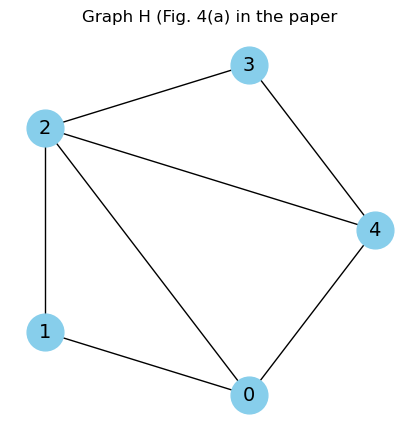

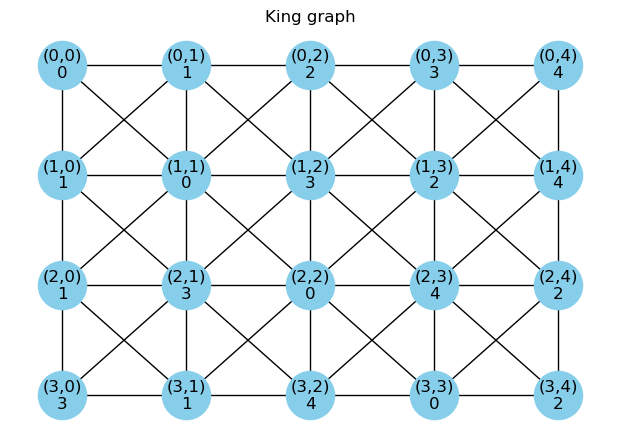

vi = 0: 


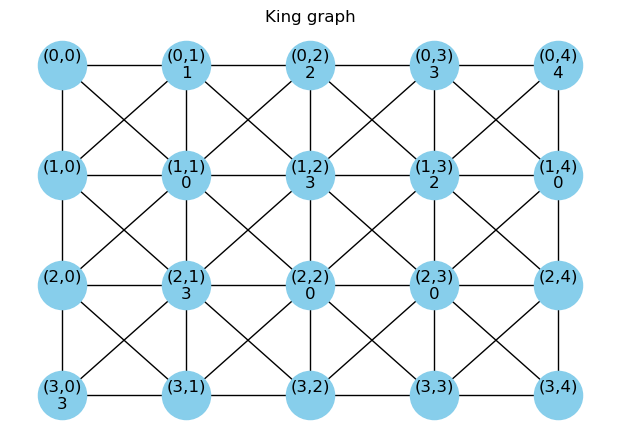

vi = 1: 


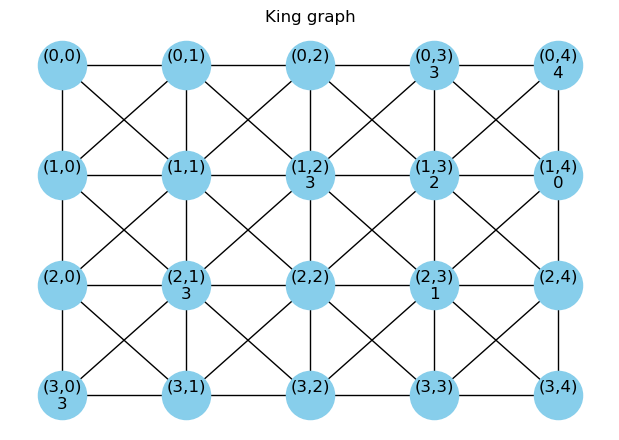

vi = 2: 


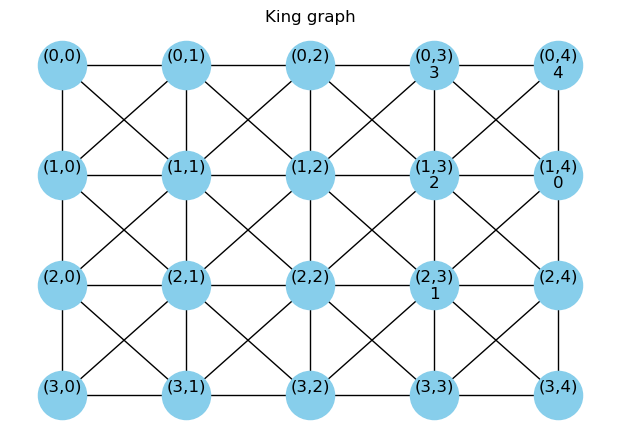

vi = 3: 


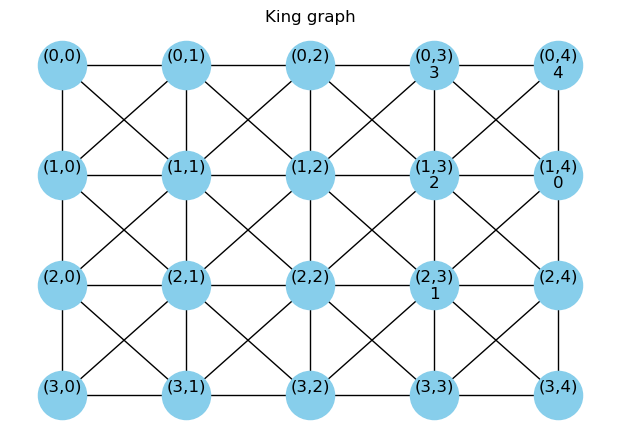

vi = 4: 


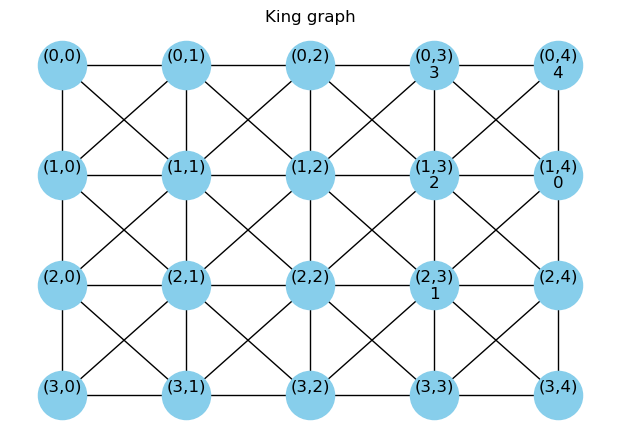

In [3]:
import networkx as nx
from collections import deque, defaultdict
import matplotlib.pyplot as plt

###############################################################
# 無向グラフの描画
def Show_Graph(H):
    # PyGraphvizのcircoレイアウトを使用してノードの位置を計算
    pos = nx.drawing.nx_agraph.graphviz_layout(H, prog='circo')

    plt.figure(figsize=(4, 4))
    nx.draw(H, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=14, font_color='black')
    plt.title('Graph H (Fig. 4(a) in the paper')
    plt.show()

###############################################################
# キンググラフ G に val 属性を追加し、グラフ H のノードの値を格納
def InitializeG(n, H_nodes):
    G = nx.grid_2d_graph(n-1, n)

    # 斜め方向のエッジを追加
    for x, y in G.nodes():
        if (x+1, y+1) in G.nodes():
            G.add_edge((x, y), (x+1, y+1))
        if (x+1, y-1) in G.nodes():
            G.add_edge((x, y), (x+1, y-1))
    
    for x, y in G.nodes():
        if x == 0:  # 第0行の場合
            G.nodes[(x, y)]['val'] = H_nodes[y]
        else:
            # x + y が偶数の場合
            if (x + y) % 2 == 0:
                G.nodes[(x, y)]['val'] = G.nodes[(x - 1, max(0, y - 1))]['val']
            # x + y が奇数の場合
            else:
                G.nodes[(x, y)]['val'] = G.nodes[(x - 1, min(n - 1, y + 1))]['val']
    return G

###############################################################
# 格子状レイアウトでキンググラフを描画
def Show_KingGraph(G):
    # yを横、-xを縦にすることで正しい表現（行, 列）になる
    pos = {(x, y): (y, -x) for x, y in G.nodes()}

    # ノードラベルを設定
    # labels = {(x, y): f"({x},{y})" for x, y in G.nodes()}
    labels = {(x, y): f"({x},{y})\n{G.nodes[(x, y)]['val']}" for x, y in G.nodes()}

    plt.figure(figsize=(6, 4))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=1200, node_color='skyblue', font_size=12, font_color='black')
    plt.title('King graph')
    plt.show()

def set_node_val(G, node, val):
    G.nodes[node]['val'] = val

def get_nodes_with_val(G, val):
    return [node for node, data in G.nodes(data=True) if data.get('val') == val]

###############################################################
def bfs_shortest_path(G, source_nodes, target_nodes):
    visited = set()
    queue = deque([(node, 0) for node in source_nodes])
    
    while queue:
        current_node, distance = queue.popleft()
        if current_node in target_nodes:
            return current_node, distance
        
        if current_node not in visited:
            visited.add(current_node)
            for neighbor in G.neighbors(current_node):
                if neighbor not in visited:
                    queue.append((neighbor, distance + 1))
    return None, float('inf')

###############################################################
def mVG(G, nodesG, nodesH):
    # Initialize the distance table
    distance_table = defaultdict(dict)
    
    # Calculate distances from nodesH to nodesG
    for val in nodesH:
        phi_val = get_nodes_with_val(G, val)
        combined_nodes = set(nodesG) | set(phi_val)
        subG = G.subgraph(combined_nodes)
        for target_node in nodesG:
            nearest_node, distance = bfs_shortest_path(subG, [target_node], phi_val)
            if target_node not in distance_table[val] or distance < distance_table[val][target_node]:
                distance_table[val][target_node] = distance

    ### Debugging: Print the distance table
    # print("Distance Table:")
    # for key, value in distance_table.items():
    #     print(f"{key}: {value}")
    # print()

    # Iterate over distances d = 1, 2, ...
    v_star = None
    for d in range(1, len(G)):
        # print(f"d = {d}")
        # Check if a vertex in G has distance d from φ(v) for all v in nodesH
        for node in nodesG:
            if all(distance_table[val][node] <= d for val in nodesH if node in distance_table[val]):
                # print(f"node: {node}, distance: {d}")
                v_star = node
                break
        if v_star is not None:
            break

    ### Debugging: Print v_star
    # print(f"v_star: {v_star}")
    # print()

    # Initialize xi with v_star
    xi = {v_star}
    
    # Update xi with vertices in the shortest path from a vertex in xi to a vertex in phi_v
    for val in nodesH:
        phi_v = get_nodes_with_val(G, val)
        new_xi = set()
        for x in xi:
            for target in phi_v:
                # Create a subgraph for path search including nodesG, xi, and phi_v nodes
                subG = G.subgraph(set(nodesG) | set(xi) | set(phi_v))

                if nx.has_path(subG, x, target):
                    path = nx.shortest_path(subG, source=x, target=target)
                    for node in path[1:-1]:
                        if node not in phi_v:
                            new_xi.add(node)
        xi.update(new_xi)
    
    return xi

###############################################################
# main文に相当する部分

###############################################################
# 論文の図4(a)のグラフ

H = nx.Graph()  # 無向グラフ (Undirected Graph)
H.add_nodes_from([0, 1, 2, 3, 4])
H.add_edges_from([(0,1), (0,2), (0,4), (1,2), (2,3), (2,4), (3,4)])

n = H.number_of_nodes()   # グラフHのノード数
H_nodes = list(H.nodes()) # グラフHのノードリスト
Show_Graph(H)

###############################################################
# (n-1)xn のキンググラフG

G = InitializeG(n, H_nodes)

Show_KingGraph(G)

for vi in H_nodes:
    ###############################################################
    # 6 - 9 行目
    print(f"vi = {vi}: ")

    # 6 行目
    for node in get_nodes_with_val(G, H_nodes[vi]):
        set_node_val(G, node, '')

    # Show_KingGraph(G)
    
    # 7 - 9 行目
    for vj in H.neighbors(vi):
        # print(f"vj = {vj}: ", end='')
        nodesH = set(H.neighbors(vj)) - {vi}
        nodesG = get_nodes_with_val(G, H_nodes[vj])
        # print(nodesH, ", ", nodesG)
        xi = mVG(G, nodesG, nodesH)
        # print("xi = ", xi)
        
        for node in get_nodes_with_val(G, H_nodes[vj]):
            set_node_val(G, node, '')
        for node in xi:
            set_node_val(G, node, H_nodes[vj])
    
        # Show_KingGraph(G)
        
    # 10 行目
    nodesG = get_nodes_with_val(G, '')
    nodesH = set(H.neighbors(vi))
    xi = mVG(G, nodesG, nodesH)
    # print("xi = ", xi)

    for node in xi:
        set_node_val(G, node, H_nodes[vi])
    
    Show_KingGraph(G)